In [1]:
# Clone your GitHub repo (you’ll be prompted to authorize if it's private)
!git clone https://github.com/colterwood/LHL-final-final-project.git

Cloning into 'LHL-final-final-project'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 221 (delta 115), reused 25 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (221/221), 4.54 MiB | 2.83 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [178]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
# load the player game logs CSV from the data folder
df = pd.read_csv("LHL-final-final-project/data/wnba_model_ready_with_top_off_def_players_v2.csv")


# preview
df.head()

,advanced_3par,advanced_ast_pct,advanced_blk_pct,advanced_drtg,advanced_ftr,advanced_ortg,advanced_pace,advanced_pace_by_team_day_of_week,advanced_stl_pct,advanced_trb_pct,...,Nneka Ogwumike,Odyssey Sims,Rebecca Allen,Rhyne Howard,Sabrina Ionescu,Satou Sabally,Stefanie Dolson,Teaira McCowan,Temi Fagbenle,Tina Charles
0,0.254,58.8,22.0,100.4,0.284,114.0,80.7,79.4,9.9,49.3,...,0,0,0,1,0,0,0,0,0,1
1,0.348,77.8,11.6,107.3,0.409,103.6,82.0,80.2,9.8,46.5,...,0,0,0,1,0,0,0,0,0,1
2,0.306,56.7,5.6,100.5,0.306,107.0,77.6,74.8,11.6,50.7,...,0,0,0,1,0,0,0,0,0,1
3,0.324,74.2,3.0,124.6,0.206,107.0,73.8,76.1,12.2,50.8,...,0,0,0,1,0,0,0,0,0,1
4,0.339,73.1,4.3,84.4,0.339,92.0,79.4,79.4,11.3,53.7,...,0,0,0,1,0,0,0,0,0,1


In [4]:
df.shape

(480, 70)

In [5]:
for col in df.columns:
  print(col)

advanced_3par
advanced_ast_pct
advanced_blk_pct
advanced_drtg
advanced_ftr
advanced_ortg
advanced_pace
advanced_pace_by_team_day_of_week
advanced_stl_pct
advanced_trb_pct
advanced_ts_pct
day
defensive_four_factors_drb_pct
defensive_four_factors_efg_pct
defensive_four_factors_ft_per_fga
defensive_four_factors_tov_pct
month
month_by_team_day_of_week
offensive_four_factors_orb_pct
offensive_four_factors_tov_pct
opponent_3p_pct
opponent_fg_pct
opponent_ft_pct
team_3p_pct
team_day_median_allowed
team_ft_pct
team_vs_opp_homeaway_median_score
team_vs_opp_median_score
team
opp
team_score
opp_score
A'ja Wilson
Aaliyah Edwards
Aari McDonald
Alanna Smith
Angel Reese
Arike Ogunbowale
Azura Stevens
Breanna Stewart
Bridget Carleton
Brittney Griner
Cameron Brink
Chelsea Gray
Chennedy Carter
Cheyenne Parker-Tyus
Diana Taurasi
Elizabeth Williams
Ezi Magbegor
Jackie Young
Jonquel Jones
Jordan Horston
Kahleah Copper
Kamilla Cardoso
Kayla McBride
Kelsey Plum
Kiah Stokes
Monique Billings
Napheesa Collier
N

In [6]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,80.99,13.99,80,88.59,8.59
1,ATL,ATL,NYL,75,80.21,5.21,81,84.87,3.87
2,ATL,ATL,CON,78,82.41,4.41,74,74.22,0.22
3,ATL,ATL,PHO,72,71.78,0.22,63,70.24,7.24
4,ATL,ATL,WAS,73,79.28,6.28,67,73.86,6.86


In [7]:
# store importances for all models
all_importances = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # get feature importances from both estimators
    team_score_importance = model.estimators_[0].feature_importances_
    opp_score_importance = model.estimators_[1].feature_importances_

    # stack into rows
    for i, feature in enumerate(X.columns):
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "team_score",
            "Importance": team_score_importance[i]
        })
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "opp_score",
            "Importance": opp_score_importance[i]
        })

# build final DataFrame
importances_df = pd.DataFrame(all_importances)

# optional: sort by importance descending
importances_df = importances_df.sort_values(by="Importance", ascending=True)

importances_df.head(20)

,Model,Feature,Target,Importance
591,IND,Alanna Smith,opp_score,0.0
1157,NYL,Kayla McBride,opp_score,0.0
603,IND,Brittney Griner,opp_score,0.0
602,IND,Brittney Griner,team_score,0.0
601,IND,Bridget Carleton,opp_score,0.0
600,IND,Bridget Carleton,team_score,0.0
599,IND,Breanna Stewart,opp_score,0.0
598,IND,Breanna Stewart,team_score,0.0
597,IND,Azura Stevens,opp_score,0.0
596,IND,Azura Stevens,team_score,0.0


In [11]:
importances_df[
    (importances_df["Model"] == "ATL") &
    (importances_df["Target"] == "team_score")
].sort_values(by="Importance", ascending=False).head(30)

,Model,Feature,Target,Importance
20,ATL,advanced_ts_pct,team_score,0.467631
10,ATL,advanced_ortg,team_score,0.234462
38,ATL,offensive_four_factors_tov_pct,team_score,0.058990
52,ATL,team_vs_opp_homeaway_median_score,team_score,0.021759
36,ATL,offensive_four_factors_orb_pct,team_score,0.017720
2,ATL,advanced_ast_pct,team_score,0.017238
44,ATL,opponent_ft_pct,team_score,0.016827
22,ATL,day,team_score,0.016160
40,ATL,opponent_3p_pct,team_score,0.015688
6,ATL,advanced_drtg,team_score,0.013513


In [12]:
importances_df[
    (importances_df["Model"] == "ATL") &
    (importances_df["Target"] == "opp_score")
].sort_values(by="Importance", ascending=False).head(30)

,Model,Feature,Target,Importance
7,ATL,advanced_drtg,opp_score,0.646872
13,ATL,advanced_pace,opp_score,0.052063
43,ATL,opponent_fg_pct,opp_score,0.049958
17,ATL,advanced_stl_pct,opp_score,0.035464
39,ATL,offensive_four_factors_tov_pct,opp_score,0.028643
33,ATL,month,opp_score,0.025776
27,ATL,defensive_four_factors_efg_pct,opp_score,0.020069
37,ATL,offensive_four_factors_orb_pct,opp_score,0.013606
5,ATL,advanced_blk_pct,opp_score,0.011956
11,ATL,advanced_ortg,opp_score,0.010455


In [13]:
# get top 30 features per target for ATL
atl_team_score_features = (
    importances_df[
        (importances_df["Model"] == "ATL") &
        (importances_df["Target"] == "team_score")
    ]
    .sort_values(by="Importance", ascending=False)
    .head(30)["Feature"]
)

atl_opp_score_features = (
    importances_df[
        (importances_df["Model"] == "ATL") &
        (importances_df["Target"] == "opp_score")
    ]
    .sort_values(by="Importance", ascending=False)
    .head(30)["Feature"]
)

# combine and deduplicate
atl_top_features = pd.concat([atl_team_score_features, atl_opp_score_features]).unique().tolist()

In [15]:
len(atl_top_features)

31

In [20]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use top features only
X = df_atl[atl_top_features]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# track meta for error calc
meta = df_atl.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# compute MAE
team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

# preview MAE summary
print("team_score MAE mean:", team_score_mae.mean())
print("opp_score MAE mean:", opp_score_mae.mean())

team_score MAE mean: 6.252500000000001
opp_score MAE mean: 5.178749999999999


In [21]:
# build predictions_df for ATL
atl_predictions_df = pd.DataFrame({
    "Model": "ATL",
    "team": meta["team"],
    "opp": meta["opp"],
    "team_score": meta["team_score"],
    "team_score_pred": y_pred[:, 0],
    "team_score_mae": team_score_mae,
    "opp_score": meta["opp_score"],
    "opp_score_pred": y_pred[:, 1],
    "opp_score_mae": opp_score_mae,
})

# compute mae_summary
atl_mae_summary = (
    atl_predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
atl_mae_summary.columns = ['_'.join(col).strip('_') for col in atl_mae_summary.columns]

atl_mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.0,13.84,6.2525,5.255,0.56,8.35,5.17875,5.575


In [22]:
atl_predictions_df.head(20)

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,80.84,13.84,80,88.35,8.35
1,ATL,ATL,NYL,75,79.92,4.92,81,84.97,3.97
2,ATL,ATL,CON,78,83.39,5.39,74,74.56,0.56
3,ATL,ATL,PHO,72,72.00,0.00,63,70.61,7.61
4,ATL,ATL,WAS,73,79.86,6.86,67,74.18,7.18
5,ATL,ATL,MIN,55,65.29,10.29,68,73.63,5.63
6,ATL,ATL,WAS,76,81.12,5.12,73,70.39,2.61
7,ATL,ATL,PHO,80,83.60,3.60,82,87.52,5.52


In [24]:
# store importances
atl_importances = []

# use selected features only
X = df_atl[atl_top_features]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)

# get feature importances from both estimators
team_score_importance = model.estimators_[0].feature_importances_
opp_score_importance = model.estimators_[1].feature_importances_

# stack into rows
for i, feature in enumerate(X.columns):
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "team_score",
        "Importance": team_score_importance[i]
    })
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "opp_score",
        "Importance": opp_score_importance[i]
    })

# build DataFrame
atl_importances_df = pd.DataFrame(atl_importances)

# sort by importance
atl_importances_df = atl_importances_df.sort_values(by="Importance", ascending=False)

atl_importances_df.head(31)

,Model,Feature,Target,Importance
19,ATL,advanced_drtg,opp_score,0.651508
0,ATL,advanced_ts_pct,team_score,0.464508
2,ATL,advanced_ortg,team_score,0.240383
4,ATL,offensive_four_factors_tov_pct,team_score,0.052548
49,ATL,advanced_pace,opp_score,0.051087
21,ATL,opponent_fg_pct,opp_score,0.047548
25,ATL,advanced_stl_pct,opp_score,0.036117
55,ATL,month,opp_score,0.030241
5,ATL,offensive_four_factors_tov_pct,opp_score,0.025435
10,ATL,advanced_ast_pct,team_score,0.022078


In [28]:
# filter to features with importance >= 0.01
atl_filtered_features_v1 = (
    atl_importances_df[atl_importances_df["Importance"] >= 0.01]["Feature"]
    .unique()
    .tolist()
)

len(atl_filtered_features_v1), atl_filtered_features_v1

(21,
 ['advanced_drtg',
  'advanced_ts_pct',
  'advanced_ortg',
  'offensive_four_factors_tov_pct',
  'advanced_pace',
  'opponent_fg_pct',
  'advanced_stl_pct',
  'month',
  'advanced_ast_pct',
  'defensive_four_factors_efg_pct',
  'offensive_four_factors_orb_pct',
  'team_vs_opp_homeaway_median_score',
  'defensive_four_factors_tov_pct',
  'opponent_3p_pct',
  'opponent_ft_pct',
  'day',
  'advanced_trb_pct',
  'team_3p_pct',
  'advanced_ftr',
  'defensive_four_factors_ft_per_fga',
  'advanced_blk_pct'])

In [29]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use top features only
X = df_atl[atl_filtered_features_v1]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# track meta for error calc
meta = df_atl.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# compute MAE
team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

# preview MAE summary
print("team_score MAE mean:", team_score_mae.mean())
print("opp_score MAE mean:", opp_score_mae.mean())

team_score MAE mean: 5.884999999999999
opp_score MAE mean: 4.811250000000001


In [31]:
# build predictions_df for ATL
atl_predictions_df = pd.DataFrame({
    "Model": "ATL",
    "team": meta["team"],
    "opp": meta["opp"],
    "team_score": meta["team_score"],
    "team_score_pred": y_pred[:, 0],
    "team_score_mae": team_score_mae,
    "opp_score": meta["opp_score"],
    "opp_score_pred": y_pred[:, 1],
    "opp_score_mae": opp_score_mae,
})

# compute mae_summary
atl_mae_summary = (
    atl_predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
atl_mae_summary.columns = ['_'.join(col).strip('_') for col in atl_mae_summary.columns]

atl_mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.17,14.0,5.885,5.43,0.09,7.43,4.81125,5.345


In [42]:
# store importances
atl_importances = []

# use selected features only
X = df_atl[atl_filtered_features_v1]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)

# get feature importances from both estimators
team_score_importance = model.estimators_[0].feature_importances_
opp_score_importance = model.estimators_[1].feature_importances_

# stack into rows
for i, feature in enumerate(X.columns):
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "team_score",
        "Importance": team_score_importance[i]
    })
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "opp_score",
        "Importance": opp_score_importance[i]
    })

# build DataFrame
atl_importances_df = pd.DataFrame(atl_importances)

# sort by importance
atl_importances_df = atl_importances_df.sort_values(by="Importance", ascending=False)

atl_importances_df.head(31)

,Model,Feature,Target,Importance
1,ATL,advanced_drtg,opp_score,0.649995
2,ATL,advanced_ts_pct,team_score,0.448431
4,ATL,advanced_ortg,team_score,0.261853
9,ATL,advanced_pace,opp_score,0.060907
6,ATL,offensive_four_factors_tov_pct,team_score,0.056261
11,ATL,opponent_fg_pct,opp_score,0.051208
13,ATL,advanced_stl_pct,opp_score,0.038075
7,ATL,offensive_four_factors_tov_pct,opp_score,0.032579
15,ATL,month,opp_score,0.026891
20,ATL,offensive_four_factors_orb_pct,team_score,0.026412


In [41]:
atl_importances_df

,Model,Feature,Target,Importance
1,ATL,advanced_drtg,opp_score,0.649995
2,ATL,advanced_ts_pct,team_score,0.448431
4,ATL,advanced_ortg,team_score,0.261853
9,ATL,advanced_pace,opp_score,0.060907
6,ATL,offensive_four_factors_tov_pct,team_score,0.056261
11,ATL,opponent_fg_pct,opp_score,0.051208
13,ATL,advanced_stl_pct,opp_score,0.038075
7,ATL,offensive_four_factors_tov_pct,opp_score,0.032579
15,ATL,month,opp_score,0.026891
20,ATL,offensive_four_factors_orb_pct,team_score,0.026412


In [44]:
atl_importances_df["Feature"].nunique()

21

In [48]:
# compute average importance per feature
worst_features = (
    atl_importances_df
    .groupby("Feature")["Importance"]
    .mean()
    .sort_values()
    .head(5)
    .index
    .tolist()
)

In [49]:
atl_filtered_features_v2 = [f for f in atl_filtered_features_v1 if f not in worst_features]

In [50]:
len(atl_filtered_features_v2)

16

In [51]:
atl_filtered_features_v2

['advanced_drtg',
 'advanced_ts_pct',
 'advanced_ortg',
 'offensive_four_factors_tov_pct',
 'advanced_pace',
 'opponent_fg_pct',
 'advanced_stl_pct',
 'month',
 'advanced_ast_pct',
 'defensive_four_factors_efg_pct',
 'offensive_four_factors_orb_pct',
 'team_vs_opp_homeaway_median_score',
 'opponent_3p_pct',
 'day',
 'advanced_trb_pct',
 'defensive_four_factors_ft_per_fga']

In [55]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use top features only
X = df_atl[atl_filtered_features_v2]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# track meta for error calc
meta = df_atl.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# compute MAE
team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

# preview MAE summary
print("team_score MAE mean:", team_score_mae.mean())
print("opp_score MAE mean:", opp_score_mae.mean())

team_score MAE mean: 5.806250000000001
opp_score MAE mean: 4.793749999999999


In [56]:
# build predictions_df for ATL
atl_predictions_df = pd.DataFrame({
    "Model": "ATL",
    "team": meta["team"],
    "opp": meta["opp"],
    "team_score": meta["team_score"],
    "team_score_pred": y_pred[:, 0],
    "team_score_mae": team_score_mae,
    "opp_score": meta["opp_score"],
    "opp_score_pred": y_pred[:, 1],
    "opp_score_mae": opp_score_mae,
})

# compute mae_summary
atl_mae_summary = (
    atl_predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
atl_mae_summary.columns = ['_'.join(col).strip('_') for col in atl_mae_summary.columns]

atl_mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.45,13.16,5.80625,5.075,0.29,8.08,4.79375,4.99


In [57]:
# store importances
atl_importances = []

# use selected features only
X = df_atl[atl_filtered_features_v2]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)

# get feature importances from both estimators
team_score_importance = model.estimators_[0].feature_importances_
opp_score_importance = model.estimators_[1].feature_importances_

# stack into rows
for i, feature in enumerate(X.columns):
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "team_score",
        "Importance": team_score_importance[i]
    })
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "opp_score",
        "Importance": opp_score_importance[i]
    })

# build DataFrame
atl_importances_df = pd.DataFrame(atl_importances)

# sort by importance
atl_importances_df = atl_importances_df.sort_values(by="Importance", ascending=False)

atl_importances_df.head(31)

,Model,Feature,Target,Importance
1,ATL,advanced_drtg,opp_score,0.660544
2,ATL,advanced_ts_pct,team_score,0.492896
4,ATL,advanced_ortg,team_score,0.246059
9,ATL,advanced_pace,opp_score,0.067252
6,ATL,offensive_four_factors_tov_pct,team_score,0.062406
11,ATL,opponent_fg_pct,opp_score,0.060878
13,ATL,advanced_stl_pct,opp_score,0.042646
7,ATL,offensive_four_factors_tov_pct,opp_score,0.036869
15,ATL,month,opp_score,0.029970
20,ATL,offensive_four_factors_orb_pct,team_score,0.023977


In [58]:
atl_importances_df["Feature"].nunique()

16

In [59]:
worst_features = []

# compute average importance per feature
worst_features = (
    atl_importances_df
    .groupby("Feature")["Importance"]
    .mean()
    .sort_values()
    .head(5)
    .index
    .tolist()
)

In [60]:
atl_filtered_features_v3 = [f for f in atl_filtered_features_v2 if f not in worst_features]

In [61]:
len(atl_filtered_features_v3)

11

In [63]:
atl_filtered_features_v3

['advanced_drtg',
 'advanced_ts_pct',
 'advanced_ortg',
 'offensive_four_factors_tov_pct',
 'advanced_pace',
 'opponent_fg_pct',
 'advanced_stl_pct',
 'month',
 'advanced_ast_pct',
 'offensive_four_factors_orb_pct',
 'day']

In [64]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use top features only
X = df_atl[atl_filtered_features_v3]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# track meta for error calc
meta = df_atl.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# compute MAE
team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

# preview MAE summary
print("team_score MAE mean:", team_score_mae.mean())
print("opp_score MAE mean:", opp_score_mae.mean())

team_score MAE mean: 5.75625
opp_score MAE mean: 4.609999999999998


In [65]:
# build predictions_df for ATL
atl_predictions_df = pd.DataFrame({
    "Model": "ATL",
    "team": meta["team"],
    "opp": meta["opp"],
    "team_score": meta["team_score"],
    "team_score_pred": y_pred[:, 0],
    "team_score_mae": team_score_mae,
    "opp_score": meta["opp_score"],
    "opp_score_pred": y_pred[:, 1],
    "opp_score_mae": opp_score_mae,
})

# compute mae_summary
atl_mae_summary = (
    atl_predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
atl_mae_summary.columns = ['_'.join(col).strip('_') for col in atl_mae_summary.columns]

atl_mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.39,14.17,5.75625,4.995,0.38,7.32,4.61,4.515


In [66]:
# store importances
atl_importances = []

# use selected features only
X = df_atl[atl_filtered_features_v3]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)

# get feature importances from both estimators
team_score_importance = model.estimators_[0].feature_importances_
opp_score_importance = model.estimators_[1].feature_importances_

# stack into rows
for i, feature in enumerate(X.columns):
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "team_score",
        "Importance": team_score_importance[i]
    })
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "opp_score",
        "Importance": opp_score_importance[i]
    })

# build DataFrame
atl_importances_df = pd.DataFrame(atl_importances)

# sort by importance
atl_importances_df = atl_importances_df.sort_values(by="Importance", ascending=False)

atl_importances_df.head(31)

,Model,Feature,Target,Importance
1,ATL,advanced_drtg,opp_score,0.667843
2,ATL,advanced_ts_pct,team_score,0.471769
4,ATL,advanced_ortg,team_score,0.280248
6,ATL,offensive_four_factors_tov_pct,team_score,0.078314
9,ATL,advanced_pace,opp_score,0.077332
11,ATL,opponent_fg_pct,opp_score,0.066844
13,ATL,advanced_stl_pct,opp_score,0.046407
7,ATL,offensive_four_factors_tov_pct,opp_score,0.038432
15,ATL,month,opp_score,0.033648
20,ATL,day,team_score,0.032642


In [67]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use top features only
X = df_atl[atl_filtered_features_v1]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# track meta for error calc
meta = df_atl.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# compute MAE
team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

# preview MAE summary
print("team_score MAE mean:", team_score_mae.mean())
print("opp_score MAE mean:", opp_score_mae.mean())

team_score MAE mean: 5.884999999999999
opp_score MAE mean: 4.811250000000001


In [68]:
# build predictions_df for ATL
atl_predictions_df = pd.DataFrame({
    "Model": "ATL",
    "team": meta["team"],
    "opp": meta["opp"],
    "team_score": meta["team_score"],
    "team_score_pred": y_pred[:, 0],
    "team_score_mae": team_score_mae,
    "opp_score": meta["opp_score"],
    "opp_score_pred": y_pred[:, 1],
    "opp_score_mae": opp_score_mae,
})

# compute mae_summary
atl_mae_summary = (
    atl_predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
atl_mae_summary.columns = ['_'.join(col).strip('_') for col in atl_mae_summary.columns]

atl_mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.17,14.0,5.885,5.43,0.09,7.43,4.81125,5.345


In [69]:
# store importances
atl_importances = []

# use selected features only
X = df_atl[atl_filtered_features_v1]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)

# get feature importances from both estimators
team_score_importance = model.estimators_[0].feature_importances_
opp_score_importance = model.estimators_[1].feature_importances_

# stack into rows
for i, feature in enumerate(X.columns):
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "team_score",
        "Importance": team_score_importance[i]
    })
    atl_importances.append({
        "Model": "ATL",
        "Feature": feature,
        "Target": "opp_score",
        "Importance": opp_score_importance[i]
    })

# build DataFrame
atl_importances_df = pd.DataFrame(atl_importances)

# sort by importance
atl_importances_df = atl_importances_df.sort_values(by="Importance", ascending=False)

atl_importances_df.head(31)

,Model,Feature,Target,Importance
1,ATL,advanced_drtg,opp_score,0.649995
2,ATL,advanced_ts_pct,team_score,0.448431
4,ATL,advanced_ortg,team_score,0.261853
9,ATL,advanced_pace,opp_score,0.060907
6,ATL,offensive_four_factors_tov_pct,team_score,0.056261
11,ATL,opponent_fg_pct,opp_score,0.051208
13,ATL,advanced_stl_pct,opp_score,0.038075
7,ATL,offensive_four_factors_tov_pct,opp_score,0.032579
15,ATL,month,opp_score,0.026891
20,ATL,offensive_four_factors_orb_pct,team_score,0.026412


In [73]:
worst_features = []

# compute average importance per feature
worst_features = (
    atl_importances_df
    .groupby("Feature")["Importance"]
    .mean()
    .sort_values()
    .head(1)
    .index
    .tolist()
)

In [74]:
atl_filtered_features_v4 = [f for f in atl_filtered_features_v1 if f not in worst_features]

In [75]:
len(atl_filtered_features_v4)

20

In [76]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use top features only
X = df_atl[atl_filtered_features_v4]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# track meta for error calc
meta = df_atl.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# compute MAE
team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

# preview MAE summary
print("team_score MAE mean:", team_score_mae.mean())
print("opp_score MAE mean:", opp_score_mae.mean())

team_score MAE mean: 6.21125
opp_score MAE mean: 4.764999999999999


In [77]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use top features only
X = df_atl[atl_top_features]
y = df_atl[["team_score", "opp_score"]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# track meta for error calc
meta = df_atl.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

# model
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# compute MAE
team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

# preview MAE summary
print("team_score MAE mean:", team_score_mae.mean())
print("opp_score MAE mean:", opp_score_mae.mean())

team_score MAE mean: 6.252500000000001
opp_score MAE mean: 5.178749999999999


In [78]:
# build predictions_df for ATL
atl_predictions_df = pd.DataFrame({
    "Model": "ATL",
    "team": meta["team"],
    "opp": meta["opp"],
    "team_score": meta["team_score"],
    "team_score_pred": y_pred[:, 0],
    "team_score_mae": team_score_mae,
    "opp_score": meta["opp_score"],
    "opp_score_pred": y_pred[:, 1],
    "opp_score_mae": opp_score_mae,
})

# compute mae_summary
atl_mae_summary = (
    atl_predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
atl_mae_summary.columns = ['_'.join(col).strip('_') for col in atl_mae_summary.columns]

atl_mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.0,13.84,6.2525,5.255,0.56,8.35,5.17875,5.575


In [97]:
## team_score specific modeling
# targets
target_cols = ["team_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []
all_predictions = []

for team_name in teams:
    # subset data
    df_team = df.copy() if team_name == "League" else df[df["team"] == team_name].copy()

    # features and target
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track meta for error calc
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train.values.ravel())  # flatten target for single output

    # predict
    y_pred = model.predict(X_test)

    # compute MAE
    team_score_mae = np.abs(y_pred - meta["team_score"].values)

    # store row-level predictions
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i],
            "team_score_mae": team_score_mae[i]
        })

    # overall metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results.append({
        "Model": team_name,
        "Target": "team_score",
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    })

# final outputs
predictions_df = pd.DataFrame(all_predictions)
results_df = pd.DataFrame(results)

In [98]:
# store importances for team_score only
all_importances = []

for team_name in teams:
    # subset data
    df_team = df.copy() if team_name == "League" else df[df["team"] == team_name].copy()

    # features and single target
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team["team_score"]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # feature importances
    importances = model.feature_importances_

    for i, feature in enumerate(X.columns):
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "team_score",
            "Importance": importances[i]
        })

# build and sort DataFrame
importances_df = pd.DataFrame(all_importances)
importances_df = importances_df.sort_values(by="Importance", ascending=False)

importances_df.head(20)

,Model,Feature,Target,Importance
731,WAS,advanced_ortg,team_score,0.797798
797,League,advanced_ortg,team_score,0.790801
335,LAS,advanced_ortg,team_score,0.703566
137,CON,advanced_ortg,team_score,0.660985
533,NYL,advanced_ortg,team_score,0.643545
203,DAL,advanced_ortg,team_score,0.591084
71,CHI,advanced_ortg,team_score,0.573683
472,MIN,advanced_ts_pct,team_score,0.511985
665,SEA,advanced_ortg,team_score,0.508534
599,PHO,advanced_ortg,team_score,0.474939


In [100]:
importances_df[
    (importances_df["Model"] == "ATL") &
    (importances_df["Target"] == "team_score")
].sort_values(by="Importance", ascending=False).head(50)

,Model,Feature,Target,Importance
10,ATL,advanced_ts_pct,team_score,0.467631
5,ATL,advanced_ortg,team_score,0.234462
19,ATL,offensive_four_factors_tov_pct,team_score,0.058990
26,ATL,team_vs_opp_homeaway_median_score,team_score,0.021759
18,ATL,offensive_four_factors_orb_pct,team_score,0.017720
1,ATL,advanced_ast_pct,team_score,0.017238
22,ATL,opponent_ft_pct,team_score,0.016827
11,ATL,day,team_score,0.016160
20,ATL,opponent_3p_pct,team_score,0.015688
3,ATL,advanced_drtg,team_score,0.013513


In [84]:
atl_team_score_features_v1 = (
    importances_df[
        (importances_df["Model"] == "ATL") &
        (importances_df["Target"] == "team_score") &
        (importances_df["Importance"] >= 0.001)
    ]["Feature"]
    .unique()
    .tolist()
)

In [87]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for team_score
X = df_atl[atl_team_score_features_v1]
y = df_atl["team_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
team_score_mae = np.abs(y_pred - y_test.values)

# summary
print("team_score MAE mean:", team_score_mae.mean())
print("team_score MAE median:", np.median(team_score_mae))
print("team_score MAE min:", team_score_mae.min())
print("team_score MAE max:", team_score_mae.max())

team_score MAE mean: 6.246249999999998
team_score MAE median: 5.285000000000004
team_score MAE min: 1.6299999999999955
team_score MAE max: 14.099999999999994


In [96]:
# extract and view importances
team_score_importances = model.feature_importances_

# build importance DataFrame
atl_team_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": team_score_importances
}).sort_values(by="Importance", ascending=False)

atl_team_score_importances_df.head(40)

,Feature,Importance
0,advanced_ts_pct,0.491288
1,advanced_ortg,0.259768
2,offensive_four_factors_tov_pct,0.063476
7,advanced_ast_pct,0.030855
4,team_vs_opp_homeaway_median_score,0.029799
3,offensive_four_factors_orb_pct,0.027087
8,opponent_3p_pct,0.023841
10,opponent_ft_pct,0.020131
5,opponent_fg_pct,0.019483
6,day,0.017797


In [89]:
atl_team_score_features_v2 = (
    atl_team_score_importances_df[atl_team_score_importances_df["Importance"] >= 0.01]["Feature"]
    .tolist()
)

In [90]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for team_score
X = df_atl[atl_team_score_features_v2]
y = df_atl["team_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
team_score_mae = np.abs(y_pred - y_test.values)

# summary
print("team_score MAE mean:", team_score_mae.mean())
print("team_score MAE median:", np.median(team_score_mae))
print("team_score MAE min:", team_score_mae.min())
print("team_score MAE max:", team_score_mae.max())

team_score MAE mean: 5.9275
team_score MAE median: 5.055
team_score MAE min: 0.45000000000000284
team_score MAE max: 12.790000000000006


In [91]:
# extract and view importances
team_score_importances = model.feature_importances_

# build importance DataFrame
atl_team_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": team_score_importances
}).sort_values(by="Importance", ascending=False)

atl_team_score_importances_df.head(20)

,Feature,Importance
0,advanced_ts_pct,0.472321
1,advanced_ortg,0.253900
2,offensive_four_factors_tov_pct,0.057035
3,offensive_four_factors_orb_pct,0.027663
8,advanced_ast_pct,0.026602
12,opponent_ft_pct,0.023053
4,team_vs_opp_homeaway_median_score,0.022718
6,day,0.022495
9,opponent_3p_pct,0.021373
11,defensive_four_factors_ft_per_fga,0.021275


In [92]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for team_score
X = df_atl[[f for f in atl_team_score_features_v2 if f != "advanced_trb_pct"]]
y = df_atl["team_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
team_score_mae = np.abs(y_pred - y_test.values)

# summary
print("team_score MAE mean:", team_score_mae.mean())
print("team_score MAE median:", np.median(team_score_mae))
print("team_score MAE min:", team_score_mae.min())
print("team_score MAE max:", team_score_mae.max())

team_score MAE mean: 5.303749999999999
team_score MAE median: 4.839999999999996
team_score MAE min: 0.04000000000000625
team_score MAE max: 13.280000000000001


In [93]:
# extract and view importances
team_score_importances = model.feature_importances_

# build importance DataFrame
atl_team_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": team_score_importances
}).sort_values(by="Importance", ascending=False)

atl_team_score_importances_df.head(20)

,Feature,Importance
0,advanced_ts_pct,0.460524
1,advanced_ortg,0.282778
2,offensive_four_factors_tov_pct,0.061833
4,team_vs_opp_homeaway_median_score,0.029151
9,opponent_3p_pct,0.027137
8,advanced_ast_pct,0.026958
6,day,0.023494
3,offensive_four_factors_orb_pct,0.022867
11,opponent_ft_pct,0.019361
5,opponent_fg_pct,0.016341


In [94]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for team_score
X = df_atl[[f for f in atl_team_score_features_v2 if f not in ["advanced_trb_pct", "advanced_drtg"]]]
y = df_atl["team_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
team_score_mae = np.abs(y_pred - y_test.values)

# summary
print("team_score MAE mean:", team_score_mae.mean())
print("team_score MAE median:", np.median(team_score_mae))
print("team_score MAE min:", team_score_mae.min())
print("team_score MAE max:", team_score_mae.max())

team_score MAE mean: 5.277500000000003
team_score MAE median: 4.690000000000005
team_score MAE min: 0.3400000000000034
team_score MAE max: 12.400000000000006


In [95]:
# extract and view importances
team_score_importances = model.feature_importances_

# build importance DataFrame
atl_team_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": team_score_importances
}).sort_values(by="Importance", ascending=False)

atl_team_score_importances_df.head(20)

,Feature,Importance
0,advanced_ts_pct,0.491288
1,advanced_ortg,0.259768
2,offensive_four_factors_tov_pct,0.063476
7,advanced_ast_pct,0.030855
4,team_vs_opp_homeaway_median_score,0.029799
3,offensive_four_factors_orb_pct,0.027087
8,opponent_3p_pct,0.023841
10,opponent_ft_pct,0.020131
5,opponent_fg_pct,0.019483
6,day,0.017797


In [101]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for team_score
X = df_atl[[f for f in atl_team_score_features_v2 if f not in [
    "advanced_trb_pct",
    "advanced_drtg",
    "defensive_four_factors_ft_per_fga"
]]]
y = df_atl["team_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
team_score_mae = np.abs(y_pred - y_test.values)

# summary
print("team_score MAE mean:", team_score_mae.mean())
print("team_score MAE median:", np.median(team_score_mae))
print("team_score MAE min:", team_score_mae.min())
print("team_score MAE max:", team_score_mae.max())

team_score MAE mean: 5.6125
team_score MAE median: 4.825000000000003
team_score MAE min: 1.1299999999999955
team_score MAE max: 12.560000000000002


In [102]:
# extract and view importances
team_score_importances = model.feature_importances_

# build importance DataFrame
atl_team_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": team_score_importances
}).sort_values(by="Importance", ascending=False)

atl_team_score_importances_df.head(20)

,Feature,Importance
0,advanced_ts_pct,0.488436
1,advanced_ortg,0.257349
2,offensive_four_factors_tov_pct,0.068373
4,team_vs_opp_homeaway_median_score,0.032254
6,day,0.029892
3,offensive_four_factors_orb_pct,0.029402
7,advanced_ast_pct,0.027590
8,opponent_3p_pct,0.026489
9,opponent_ft_pct,0.023051
5,opponent_fg_pct,0.017164


In [103]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for team_score
X = df_atl[[f for f in atl_team_score_features_v2 if f not in [
    "advanced_trb_pct",
    "advanced_drtg",
    "defensive_four_factors_ft_per_fga",
    "opponent_fg_pct"
]]]
y = df_atl["team_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
team_score_mae = np.abs(y_pred - y_test.values)

# summary
print("team_score MAE mean:", team_score_mae.mean())
print("team_score MAE median:", np.median(team_score_mae))
print("team_score MAE min:", team_score_mae.min())
print("team_score MAE max:", team_score_mae.max())

team_score MAE mean: 5.914999999999999
team_score MAE median: 5.094999999999999
team_score MAE min: 1.3499999999999943
team_score MAE max: 12.849999999999994


In [104]:
# Features for best team_score model for ATL
atl_team_score_final_features = [
    f for f in atl_team_score_features_v2
    if f not in ["advanced_trb_pct", "advanced_drtg"]
]

In [116]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# full feature set
X = df_atl.drop(columns=["team", "opp", "team_score", "opp_score"])
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# extract importances
atl_opp_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

atl_opp_score_importances_df.head(40)

,Feature,Importance
3,advanced_drtg,0.646872
6,advanced_pace,0.052063
21,opponent_fg_pct,0.049958
8,advanced_stl_pct,0.035464
19,offensive_four_factors_tov_pct,0.028643
16,month,0.025776
13,defensive_four_factors_efg_pct,0.020069
18,offensive_four_factors_orb_pct,0.013606
2,advanced_blk_pct,0.011956
5,advanced_ortg,0.010455


In [117]:
atl_opp_score_features_v1 = (
    atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
    .tolist()
)

In [118]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for opp_score
X = df_atl[atl_opp_score_features_v1]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", opp_score_mae.min())
print("opp_score MAE max:", opp_score_mae.max())

opp_score MAE mean: 5.0337499999999995
opp_score MAE median: 5.534999999999997
opp_score MAE min: 0.5999999999999943
opp_score MAE max: 8.950000000000003


In [119]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# full feature set
X = df_atl[atl_opp_score_features_v1]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# extract importances
atl_opp_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

atl_opp_score_importances_df.head(50)

,Feature,Importance
0,advanced_drtg,0.651564
1,advanced_pace,0.053082
2,opponent_fg_pct,0.052833
3,advanced_stl_pct,0.035141
4,offensive_four_factors_tov_pct,0.025912
5,month,0.025103
7,offensive_four_factors_orb_pct,0.016315
6,defensive_four_factors_efg_pct,0.014834
9,advanced_ortg,0.013875
8,advanced_blk_pct,0.011367


In [121]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for opp_score
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f != "Tina Charles"]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", opp_score_mae.min())
print("opp_score MAE max:", opp_score_mae.max())

opp_score MAE mean: 5.042499999999999
opp_score MAE median: 5.125
opp_score MAE min: 0.01999999999999602
opp_score MAE max: 8.530000000000001


In [122]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# full feature set
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f != "Tina Charles"]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# extract importances
atl_opp_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

atl_opp_score_importances_df.head(40)

,Feature,Importance
0,advanced_drtg,0.649413
2,opponent_fg_pct,0.054964
1,advanced_pace,0.054560
3,advanced_stl_pct,0.035216
5,month,0.031674
4,offensive_four_factors_tov_pct,0.023118
6,offensive_four_factors_orb_pct,0.018881
8,advanced_ftr,0.017477
7,defensive_four_factors_tov_pct,0.012025
9,advanced_blk_pct,0.010740


In [123]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for opp_score
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f not in ["Tina Charles", "month_by_team_day_of_week"]]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", opp_score_mae.min())
print("opp_score MAE max:", opp_score_mae.max())

opp_score MAE mean: 4.958749999999998
opp_score MAE median: 5.544999999999995
opp_score MAE min: 0.23999999999999488
opp_score MAE max: 8.450000000000003


In [124]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# full feature set
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f not in ["Tina Charles", "month_by_team_day_of_week"]]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# extract importances
atl_opp_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

atl_opp_score_importances_df.head(40)

,Feature,Importance
0,advanced_drtg,0.644660
2,advanced_pace,0.053844
1,opponent_fg_pct,0.052049
3,advanced_stl_pct,0.033820
4,month,0.026794
5,offensive_four_factors_tov_pct,0.025006
11,defensive_four_factors_efg_pct,0.021120
7,advanced_ftr,0.015469
6,offensive_four_factors_orb_pct,0.015006
8,defensive_four_factors_tov_pct,0.011824


In [126]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for opp_score
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f not in [
         "Tina Charles",
         "month_by_team_day_of_week",
         "team_day_median_allowed",
         "advanced_trb_pct",
         "team_ft_pct",
         "advanced_blk_pct",
         "advanced_ast_pct",
         "team_vs_opp_homeaway_median_score",
         "opponent_ft_pct",
         "opponent_3p_pct",
         "defensive_four_factors_drb_pct",
         "advanced_ts_pct",
         "defensive_four_factors_ft_per_fga",
         "team_3p_pct",
         "advanced_pace_by_team_day_of_week",
         "advanced_3par",
         "day",
         "team_vs_opp_median_score",
         "Cheyenne Parker-Tyus",
         "Rhyne Howard"
     ]]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", opp_score_mae.min())
print("opp_score MAE max:", opp_score_mae.max())

opp_score MAE mean: 4.722499999999998
opp_score MAE median: 5.030000000000001
opp_score MAE min: 0.4899999999999949
opp_score MAE max: 7.689999999999998


In [127]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for opp_score
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f not in [
         "Tina Charles",
         "month_by_team_day_of_week",
         "team_day_median_allowed",
        #  "advanced_trb_pct",
         "team_ft_pct",
         "advanced_blk_pct",
         "advanced_ast_pct",
         "team_vs_opp_homeaway_median_score",
         "opponent_ft_pct",
         "opponent_3p_pct",
         "defensive_four_factors_drb_pct",
         "advanced_ts_pct",
         "defensive_four_factors_ft_per_fga",
         "team_3p_pct",
         "advanced_pace_by_team_day_of_week",
         "advanced_3par",
         "day",
         "team_vs_opp_median_score",
         "Cheyenne Parker-Tyus",
         "Rhyne Howard"
     ]]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", opp_score_mae.min())
print("opp_score MAE max:", opp_score_mae.max())

opp_score MAE mean: 4.963749999999999
opp_score MAE median: 4.859999999999999
opp_score MAE min: 0.5799999999999983
opp_score MAE max: 7.670000000000002


In [128]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# full feature set
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f not in [
         "Tina Charles",
         "month_by_team_day_of_week",
         "team_day_median_allowed",
         "advanced_trb_pct",
         "team_ft_pct",
         "advanced_blk_pct",
         "advanced_ast_pct",
         "team_vs_opp_homeaway_median_score",
         "opponent_ft_pct",
         "opponent_3p_pct",
         "defensive_four_factors_drb_pct",
         "advanced_ts_pct",
         "defensive_four_factors_ft_per_fga",
         "team_3p_pct",
         "advanced_pace_by_team_day_of_week",
         "advanced_3par",
         "day",
         "team_vs_opp_median_score",
         "Cheyenne Parker-Tyus",
         "Rhyne Howard"
     ]]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# extract importances
atl_opp_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

atl_opp_score_importances_df.head(40)

,Feature,Importance
0,advanced_drtg,0.658632
1,advanced_pace,0.073219
2,opponent_fg_pct,0.050919
3,advanced_stl_pct,0.043738
5,offensive_four_factors_tov_pct,0.032923
8,offensive_four_factors_orb_pct,0.031719
4,month,0.029175
6,defensive_four_factors_efg_pct,0.024322
7,advanced_ftr,0.021430
9,defensive_four_factors_tov_pct,0.018334


In [130]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for opp_score
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f not in [
         "Tina Charles",
         "month_by_team_day_of_week",
         "team_day_median_allowed",
         "advanced_trb_pct",
         "team_ft_pct",
         "advanced_blk_pct",
         "advanced_ast_pct",
         "team_vs_opp_homeaway_median_score",
         "opponent_ft_pct",
         "opponent_3p_pct",
         "defensive_four_factors_drb_pct",
         "advanced_ts_pct",
         "defensive_four_factors_ft_per_fga",
         "team_3p_pct",
         "advanced_pace_by_team_day_of_week",
         "advanced_3par",
         "day",
         "team_vs_opp_median_score",
         "Cheyenne Parker-Tyus",
         "Rhyne Howard",
         "advanced_ortg"
     ]]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", opp_score_mae.min())
print("opp_score MAE max:", opp_score_mae.max())

opp_score MAE mean: 4.70125
opp_score MAE median: 4.625
opp_score MAE min: 0.37999999999999545
opp_score MAE max: 8.180000000000007


In [131]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# full feature set
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f not in [
         "Tina Charles",
         "month_by_team_day_of_week",
         "team_day_median_allowed",
         "advanced_trb_pct",
         "team_ft_pct",
         "advanced_blk_pct",
         "advanced_ast_pct",
         "team_vs_opp_homeaway_median_score",
         "opponent_ft_pct",
         "opponent_3p_pct",
         "defensive_four_factors_drb_pct",
         "advanced_ts_pct",
         "defensive_four_factors_ft_per_fga",
         "team_3p_pct",
         "advanced_pace_by_team_day_of_week",
         "advanced_3par",
         "day",
         "team_vs_opp_median_score",
         "Cheyenne Parker-Tyus",
         "Rhyne Howard",
         "advanced_ortg"
     ]]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# extract importances
atl_opp_score_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

atl_opp_score_importances_df.head(40)

,Feature,Importance
0,advanced_drtg,0.664335
1,advanced_pace,0.071796
2,opponent_fg_pct,0.058063
3,advanced_stl_pct,0.042200
6,month,0.038240
4,offensive_four_factors_tov_pct,0.028418
5,offensive_four_factors_orb_pct,0.028212
9,defensive_four_factors_tov_pct,0.026593
8,advanced_ftr,0.022848
7,defensive_four_factors_efg_pct,0.019295


In [132]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# filtered features for opp_score
X = df_atl[
    [f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
     if f not in [
         "Tina Charles",
         "month_by_team_day_of_week",
         "team_day_median_allowed",
         "advanced_trb_pct",
         "team_ft_pct",
         "advanced_blk_pct",
         "advanced_ast_pct",
         "team_vs_opp_homeaway_median_score",
         "opponent_ft_pct",
         "opponent_3p_pct",
         "defensive_four_factors_drb_pct",
         "advanced_ts_pct",
         "defensive_four_factors_ft_per_fga",
         "team_3p_pct",
         "advanced_pace_by_team_day_of_week",
         "advanced_3par",
         "day",
         "team_vs_opp_median_score",
         "Cheyenne Parker-Tyus",
         "Rhyne Howard",
         "advanced_ortg",
         "defensive_four_factors_efg_pct"
     ]]
]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# error metrics
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", opp_score_mae.min())
print("opp_score MAE max:", opp_score_mae.max())

opp_score MAE mean: 5.027499999999998
opp_score MAE median: 4.850000000000001
opp_score MAE min: 0.5499999999999972
opp_score MAE max: 8.629999999999995


In [133]:
atl_opp_score_final_features = [
    f for f in atl_opp_score_importances_df[atl_opp_score_importances_df["Importance"] > 0]["Feature"]
    if f not in [
        "Tina Charles",
        "month_by_team_day_of_week",
        "team_day_median_allowed",
        "advanced_trb_pct",
        "team_ft_pct",
        "advanced_blk_pct",
        "advanced_ast_pct",
        "team_vs_opp_homeaway_median_score",
        "opponent_ft_pct",
        "opponent_3p_pct",
        "defensive_four_factors_drb_pct",
        "advanced_ts_pct",
        "defensive_four_factors_ft_per_fga",
        "team_3p_pct",
        "advanced_pace_by_team_day_of_week",
        "advanced_3par",
        "day",
        "team_vs_opp_median_score",
        "Cheyenne Parker-Tyus",
        "Rhyne Howard",
        "advanced_ortg"
    ]
]

In [134]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.647083333333335
opp_score MAE median: 4.375
opp_score MAE min: 0.6400000000000006
opp_score MAE max: 7.700000000000003


In [136]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.63725
opp_score MAE median: 4.4680000000000035
opp_score MAE min: 0.4159999999999968
opp_score MAE max: 7.5460000000000065


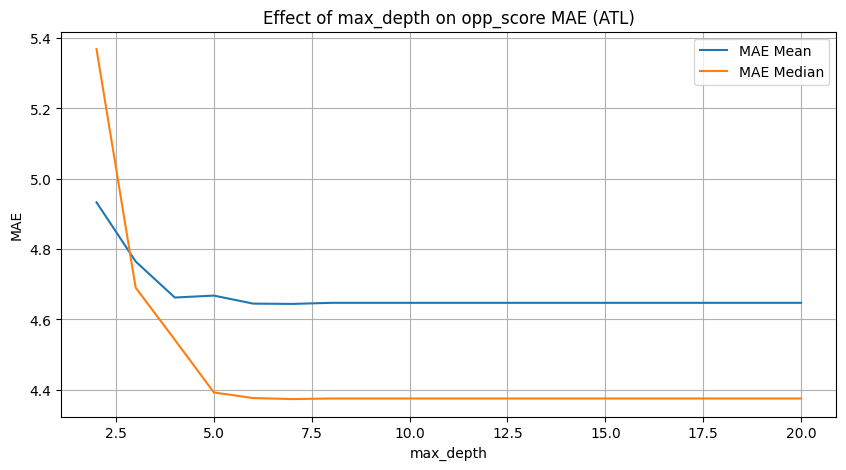

In [135]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

depths = list(range(2, 21))
mae_means = []
mae_medians = []

for depth in depths:
    model = RandomForestRegressor(n_estimators=300, max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = np.abs(y_pred - y_test.values)
    mae_means.append(mae.mean())
    mae_medians.append(np.median(mae))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(depths, mae_means, label="MAE Mean")
plt.plot(depths, mae_medians, label="MAE Median")
plt.xlabel("max_depth")
plt.ylabel("MAE")
plt.title("Effect of max_depth on opp_score MAE (ATL)")
plt.legend()
plt.grid(True)
plt.show()

In [137]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.672337085137082
opp_score MAE median: 4.5180329004328925
opp_score MAE min: 0.40059603174603353
opp_score MAE max: 7.567338888888855


In [138]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=300, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.667663495069743
opp_score MAE median: 4.392050865800854
opp_score MAE min: 0.5808703703703628
opp_score MAE max: 7.64586375661375


In [139]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=400, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.718450870310246
opp_score MAE median: 4.543213744588741
opp_score MAE min: 0.5674950396825409
opp_score MAE max: 7.591495039682528


In [140]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=300, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.644834986772487
opp_score MAE median: 4.376248677248675
opp_score MAE min: 0.6551666666666591
opp_score MAE max: 7.652571428571434


In [141]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=300, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.662131845006842
opp_score MAE median: 4.5420985264735165
opp_score MAE min: 0.6406129148629276
opp_score MAE max: 7.502432123432101


In [142]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=1000, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.566822148337751
opp_score MAE median: 4.466530606199321
opp_score MAE min: 0.0004837301587059528
opp_score MAE max: 7.388433867521329


In [143]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=300, max_depth=5, min_samples_leaf=2,random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 5.032911871693127
opp_score MAE median: 5.133190476190457
opp_score MAE min: 0.5864523809523803
opp_score MAE max: 7.705538359788406


In [147]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=300, max_depth=5, min_samples_leaf=3,random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 5.032244259212989
opp_score MAE median: 5.28851208513705
opp_score MAE min: 0.5396376493876431
opp_score MAE max: 8.207778934028909


In [148]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=300, max_depth=5, min_samples_leaf=5,random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 5.611699342361922
opp_score MAE median: 6.081147971037666
opp_score MAE min: 0.4715613702459791
opp_score MAE max: 9.89199709032799


In [150]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=300, max_depth=5, min_samples_leaf=1, max_features="sqrt", random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.910727751415255
opp_score MAE median: 5.049807535057546
opp_score MAE min: 0.8103942908942798
opp_score MAE max: 10.363527777777776


In [151]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(n_estimators=300, max_depth=5, min_samples_leaf=1, max_features=None,bootstrap=False, random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 6.657638888888884
opp_score MAE median: 5.548888888888889
opp_score MAE min: 0.21555555555554662
opp_score MAE max: 16.819999999999993


In [153]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    min_samples_split=3,
    random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.785986907768148
opp_score MAE median: 4.660644119769088
opp_score MAE min: 0.7116957671957636
opp_score MAE max: 7.672628306878281


In [154]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    min_samples_split=4,
    random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.8356977212602175
opp_score MAE median: 4.863588564213551
opp_score MAE min: 0.792771164021147
opp_score MAE max: 7.7023280423280625


In [155]:
# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()

# use final feature set
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model with more trees
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    min_samples_split=2,
    random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.667663495069743
opp_score MAE median: 4.392050865800854
opp_score MAE min: 0.5808703703703628
opp_score MAE max: 7.64586375661375


In [156]:
# Best RandomForest model for ATL opp_score
atl_opp_score_rf_final = model

# Predictions from atl_opp_score_rf_final
atl_opp_score_rf_preds = y_pred

# Lock final feature list
atl_opp_score_final_features = list(X.columns)

# Lock final config
atl_opp_score_rf_config = {
    "n_estimators": 300,
    "max_depth": 5,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "max_features": None,
    "bootstrap": True,
    "random_state": 42
}

In [158]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,  # default
    subsample=1.0,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.5548529624938965
opp_score MAE median: 3.013538360595703
opp_score MAE min: 0.9979743957519531
opp_score MAE max: 7.599601745605469


In [159]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=1.0,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.5293898582458496
opp_score MAE median: 3.2303733825683594
opp_score MAE min: 0.743804931640625
opp_score MAE max: 7.3526458740234375


In [160]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,  # default
    subsample=1.0,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.1864013671875
opp_score MAE median: 4.4309539794921875
opp_score MAE min: 0.13248443603515625
opp_score MAE max: 7.0574493408203125


In [161]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=1.0,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.5296950340270996
opp_score MAE median: 3.226490020751953
opp_score MAE min: 0.7436370849609375
opp_score MAE max: 7.3524017333984375


In [162]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,  # default
    subsample=1.0,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.5548529624938965
opp_score MAE median: 3.013538360595703
opp_score MAE min: 0.9979743957519531
opp_score MAE max: 7.599601745605469


In [165]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,  # default
    subsample=1.0,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.5548529624938965
opp_score MAE median: 3.013538360595703
opp_score MAE min: 0.9979743957519531
opp_score MAE max: 7.599601745605469


In [164]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,  # default
    subsample=1.0,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.5548529624938965
opp_score MAE median: 3.013538360595703
opp_score MAE min: 0.9979743957519531
opp_score MAE max: 7.599601745605469


In [166]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=1.0,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.5296950340270996
opp_score MAE median: 3.226490020751953
opp_score MAE min: 0.7436370849609375
opp_score MAE max: 7.3524017333984375


In [167]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=0.8,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.107283592224121
opp_score MAE median: 2.6647491455078125
opp_score MAE min: 0.01474761962890625
opp_score MAE max: 6.2743682861328125


In [168]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=0.6,      # use full dataset per tree
    colsample_bytree=1.0,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.308023452758789
opp_score MAE median: 2.4794654846191406
opp_score MAE min: 0.39347076416015625
opp_score MAE max: 6.444183349609375


In [169]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=0.8,      # use full dataset per tree
    colsample_bytree=0.8,  # use all features
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.2709760665893555
opp_score MAE median: 2.872974395751953
opp_score MAE min: 0.016082763671875
opp_score MAE max: 6.839912414550781


In [171]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=0.8,      # use full dataset per tree
    colsample_bytree=1,  # use all features
    random_state=42,
    verbosity=0,
    min_child_weight=3
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 4.656493186950684
opp_score MAE median: 5.565105438232422
opp_score MAE min: 0.22106170654296875
opp_score MAE max: 10.378555297851562


In [172]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=0.8,      # use full dataset per tree
    colsample_bytree=1,  # use all features
    random_state=42,
    verbosity=0,
    min_child_weight=1,
    reg_alpha=0.1
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.1958236694335938
opp_score MAE median: 2.693675994873047
opp_score MAE min: 0.18701934814453125
opp_score MAE max: 6.282325744628906


In [173]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=0.8,      # use full dataset per tree
    colsample_bytree=1,  # use all features
    random_state=42,
    verbosity=0,
    min_child_weight=1,
    reg_alpha=0.5
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.639026641845703
opp_score MAE median: 3.2500267028808594
opp_score MAE min: 1.2506790161132812
opp_score MAE max: 6.826896667480469


In [174]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=0.8,      # use full dataset per tree
    colsample_bytree=1,  # use all features
    random_state=42,
    verbosity=0,
    min_child_weight=1,
    reg_lambda=0.1
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.81467342376709
opp_score MAE median: 3.2997894287109375
opp_score MAE min: 0.26055908203125
opp_score MAE max: 7.6075592041015625


In [175]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,  # default
    subsample=0.8,      # use full dataset per tree
    colsample_bytree=1,  # use all features
    random_state=42,
    verbosity=0,
    min_child_weight=1,
    reg_lambda=0.1,
    reg_alpha=0.1
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.759921073913574
opp_score MAE median: 3.3881988525390625
opp_score MAE min: 0.15508270263671875
opp_score MAE max: 7.497642517089844


In [176]:
from xgboost import XGBRegressor

# subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model (initial test config)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=1,
    random_state=42,
    verbosity=0,
    min_child_weight=1
)
model.fit(X_train, y_train)

# predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

opp_score MAE mean: 3.107283592224121
opp_score MAE median: 2.6647491455078125
opp_score MAE min: 0.01474761962890625
opp_score MAE max: 6.2743682861328125


In [177]:
# Save trained model
atl_opp_score_xgb_final = model

# Save predictions (optional, if you want to compare later)
atl_opp_score_xgb_preds = y_pred

# Save feature list used
atl_opp_score_final_features = list(X.columns)

# Save model config
atl_opp_score_xgb_config = {
    "model_type": "XGBoost",
    "n_estimators": 300,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "min_child_weight": 1,
    "random_state": 42
}

In [179]:
# Subset to ATL only
df_atl = df[df["team"] == "ATL"].copy()
X = df_atl[atl_opp_score_final_features]
y = df_atl["opp_score"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# LightGBM model with initial config
model = LGBMRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions + error
y_pred = model.predict(X_test)
opp_score_mae = np.abs(y_pred - y_test.values)

# Summary
print("opp_score MAE mean:", opp_score_mae.mean())
print("opp_score MAE median:", np.median(opp_score_mae))
print("opp_score MAE min:", np.min(opp_score_mae))
print("opp_score MAE max:", np.max(opp_score_mae))

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] Start training from score 81.312500
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl